In [1]:
import DeepLabModel
import os, urllib
from PIL import Image
from io import BytesIO
import numpy as np
from skimage.io import imshow
import matplotlib.pyplot as plt
from matplotlib import gridspec
from ipywidgets import FloatSlider, interact, fixed, HBox, VBox, Label, Button, Output, IntProgress, FloatProgress
%pdb 0
plt.rcParams['figure.max_open_warning'] = False
import pandas as pd
import IPython
%matplotlib inline
from skimage.measure import label

from DCSegUtils import softmax
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

import seaborn as sb
import pandas as pd

Automatic pdb calling has been turned OFF


# Combining Segmentation models using Cooperative Negotiation

## Agents and Mediator definition

In [2]:
class Agent():
    def __init__(self, agentname, model, alpha_fun):
        self.agentname=agentname
        self.model=model
        self.task = None
        self.initial_proposal = None
        self.alpha = alpha_fun
        
    def new_task(self, image):
        self.task, logits = self.model.run(image)
        logits=logits[:self.task.size[1], :self.task.size[0], ...] # Otherwise logits are a square matrix
        self.initial_proposal = softmax(logits, axis=-1)
        self.last_proposal = self.initial_proposal
        return self.initial_proposal
    
    def utility(self, proposal):
        'Returns a utility of shape (labels) between a proposal and self.optimal'
        return np.array([np.linalg.norm(self.optimal[...,l]-proposal[...,l]) for l in range(self.optimal.shape[-1])])
    
    def propose(self, agreement):
        self.last_agreement = agreement
        self.last_proposal = self.last_proposal + self.alpha(self.last_proposal)*(agreement - self.last_proposal)
        
        return self.last_proposal
    

In [3]:
class Mediator():
    def __init__(self, agents):
        self.agents = agents
        self.last_step=0
        self.W = None
        
    def start_new_task(self, image):
        self.task = image
        self.initial_proposals = np.array([agent.new_task(self.task) for agent in self.agents])
        self.last_proposals = self.initial_proposals
        self.W = np.ones_like(self.initial_proposals)
        return self.last_proposals

        
    def negotiation(self, timeout = 1000):
        for i in range(self.last_step, self.last_step+timeout):
            self.last_step = i            
            self.last_agreement = np.divide(np.sum(self.last_proposals*self.W, axis=0), np.sum(self.W, axis=0))
            
            # Propose the new agreement to the agents
            self.last_proposals = np.array([agent.propose(self.last_agreement) for agent in self.agents]) # ((p0, u0), (p1, u1), ...)

            yield self.last_agreement, self.last_proposals
        return self.last_agreement, self.last_proposals

### Loading Deep Learning Models

In [4]:
def load_models():    
    _DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
    model_dir = '../models/'
    _MODEL_URLS = {
        'mobilenetv2_coco_voctrainaug':
            'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
        'mobilenetv2_coco_voctrainval':
            'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
        'xception_coco_voctrainaug':
            'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
        'xception_coco_voctrainval':
            'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
    }
    models = dict()
    for modelname, tarname in _MODEL_URLS.items():
        download_path = os.path.join(model_dir, tarname)
        if not os.path.isfile(download_path):
            print('downloading {}, this might take a while...'.format(modelname))
            urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[modelname],
                               download_path)
            print('download completed!')
            
        else:
            print("model already present at {}".format(download_path))
        
        print('Loading model {}...'.format(modelname))
        models[modelname] = DeepLabModel.DeepLabModel(download_path)
        print('{} loaded successfully!'.format(modelname))
    return models
models = load_models()

model already present at ../models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz
Loading model mobilenetv2_coco_voctrainaug...
mobilenetv2_coco_voctrainaug loaded successfully!
model already present at ../models/deeplabv3_pascal_trainval_2018_01_04.tar.gz
Loading model xception_coco_voctrainval...
xception_coco_voctrainval loaded successfully!
model already present at ../models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz
Loading model xception_coco_voctrainaug...
xception_coco_voctrainaug loaded successfully!
model already present at ../models/deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz
Loading model mobilenetv2_coco_voctrainval...
mobilenetv2_coco_voctrainval loaded successfully!


### Visualization functions

In [6]:
def show_proposals(task, proposals):
        plt.figure(figsize=(16,9), dpi=300)
        # Finding all the labels that appear in the proposals for the legend
        unique_labels = np.array([], dtype=np.int)
        for p in proposals:
            unique_labels = np.union1d(unique_labels, np.unique(p))
        unique_labels = unique_labels[unique_labels!=255] # We ignore the void label (see VOC2012 docs)
                
        max_cols = len(proposals)+2

        grid_spec = gridspec.GridSpec(1, max_cols, width_ratios= [6] + [6 for i in proposals]+ [2])
        # Show input
        plt.subplot(grid_spec[0])
        plt.imshow(task)
        plt.axis('off')
        plt.title('Input')

        for p, prop in enumerate(proposals):
            plt.subplot(grid_spec[p+1])
            plt.imshow(DeepLabModel.label_to_color_image(prop).astype(np.uint8))
            plt.axis('off')
            plt.title('Model {}'.format(p+1))

        ax = plt.subplot(grid_spec[max_cols-1])
        plt.imshow(
            FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest', aspect=0.3)
        ax.yaxis.tick_right()
        plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
        plt.xticks([], [])
        ax.tick_params(width=0.0)
        plt.grid(False)
        plt.show()

def show_agreement(agreement, i, initial=None):
        labels = [(l,LABEL_NAMES[l]) for l in range(agreement.shape[-1])]
        if initial is None:
            plt.figure(figsize=(16,9), dpi=300)
            for lpos, lab in labels:
                agr = agreement[...,lpos]
                plt.subplot(np.ceil(np.sqrt(len(labels))), np.ceil(np.sqrt(len(labels))), lpos+1)
                plt.title("Agr {}: {}".format(i, lab))
                #plt.set_cmap('gray')
                plt.axis('off')
                plt.imshow(agr)
        else:
            plt.figure(figsize=(3*2,21*2), dpi=400)
            for lpos, lab in labels:
                agr = agreement[...,lpos]
                ini = initial[...,lpos]
                diff = agr-ini
                
                # Normalize the colormap
                cmax = max(np.max(agr), np.max(ini))
                cmin = min(np.min(agr), np.min(ini))
                norm = colors.Normalize(vmin=cmin, vmax=cmax)
                
                plt.subplot(np.ceil(len(labels)), 3, lpos*3+1)
                plt.title("Agr 0: {}".format(lab))
                #plt.set_cmap('gray')
                plt.axis('off')
                im = plt.imshow(ini)
                im.set_norm(norm)
                cb = plt.colorbar(im,fraction=0.046, pad=0.04)
                cb.ax.tick_params(labelsize='xx-small')
                
                plt.subplot(np.ceil(len(labels)), 3, lpos*3+2)
                plt.title("{}".format(i))
                #plt.set_cmap('gray')
                plt.axis('off')
                im = plt.imshow(agr)
                im.set_norm(norm)
                cb = plt.colorbar(im,fraction=0.046, pad=0.04)
                cb.ax.tick_params(labelsize='xx-small')
                
                plt.subplot(np.ceil(len(labels)), 3, lpos*3+3)
                plt.title("Diff")
                #plt.set_cmap('gray')
                plt.axis('off')
                im = plt.imshow(diff)
                cb = plt.colorbar(im,fraction=0.046, pad=0.04)
                cb.ax.tick_params(labelsize='xx-small')

def plot_segmentations(agreements):
    ''' Plots a list of agreements/proposals as a labeled segmentation '''
    nseg = len(agreements)
    edge = np.ceil(np.sqrt(nseg))
    
    plt.figure(figsize=(10*edge,10*edge))
    for i, agr in enumerate(agreements):
        plt.subplot(edge, edge, i+1)
        seg = np.argmax(agr, axis=-1).astype(np.int8)
        seg = DeepLabModel.label_to_color_image(seg).astype(np.uint8)
        im = plt.imshow(seg, interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.show()        

def plot_proposals_means(proposals, agreements):
    'Plots the average value in the agreement for each class'
    # Merge the agreemen
    props = np.asarray(proposals)
    agr = np.asarray(agreements)
    print(props.shape)
    print(agr.shape)
    return 
    plt.figure()
    for a, agreement in enumerate(agreements):
        plt.subplot(1, len(agreements), a+1)
        mean_agr = np.mean(np.array(agreement), axis=(1,2))
        cols = [LABEL_NAMES[i] for i in range(mean_agr.shape[-1])]
        pdata = pd.DataFrame(mean_agr, columns=[cols])
        pdata.plot(subplots=True, figsize=(9, 32))
    
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = DeepLabModel.label_to_color_image(FULL_LABEL_MAP)

In [ ]:
plot_proposals_means(proposals_v, agreements_v)

### Defining agent parameters

In [7]:
loaded = pd.read_csv('params.csv', index_col=0)

In [8]:

alphasliders = {m:[FloatSlider(description=l, min=0., max=1., step=0.01, value=loaded.loc[m][l]) for l in LABEL_NAMES] for m in models.keys()}
sliders = [VBox([Label(model)]+alphasliders[model]) for model in alphasliders.keys()]
HBox(sliders)

## Input Image

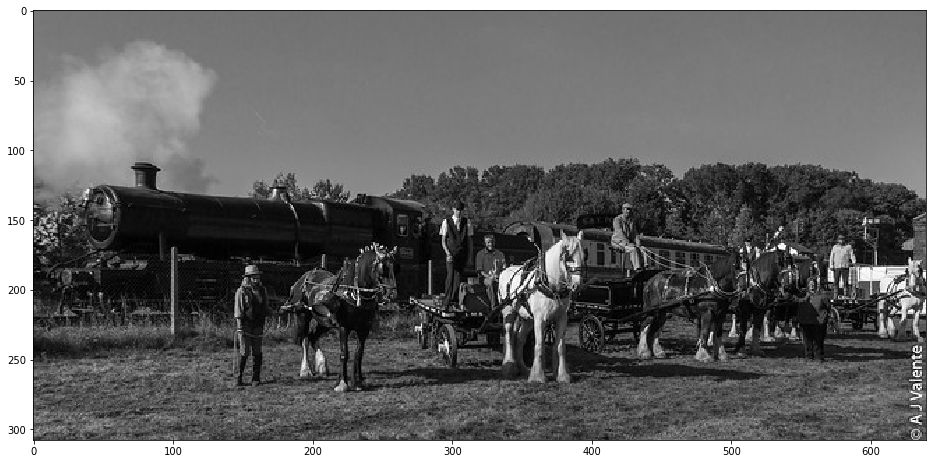

In [19]:
# Download an image and start negotiation
url = 'https://farm9.staticflickr.com/8401/10174115513_13c3650c08_z.jpg'
# Person shadows
#url = 'http://farm8.static.flickr.com/7920/47425338881_de208df2ff_m.jpg'
#url = 'https://cdn.vox-cdn.com/uploads/chorus_asset/file/8327269/Screen_Shot_2017_04_12_at_3.54.13_PM.png'
#url = 'https://proxy.duckduckgo.com/iu/?u=https%3A%2F%2Fimages.fastcompany.net%2Fimage%2Fupload%2Fw_596%2Cc_limit%2Cq_auto%3Abest%2Cf_auto%2Cfl_lossy%2Ffc%2F1683481-inline-s-2-dog-tv-share-the-remote-control.jpg&f=1'
#url = 'https://www.zastavki.com/pictures/originals/2013/People_Shadows_of_people_looked_047805_.jpg'
f = urllib.request.urlopen(url)
jpeg_str = f.read()
original_im = Image.open(BytesIO(jpeg_str))

plt.figure(figsize=(16,9));
plt.imshow(original_im)

MAX_STEPS=50

## Baseline
Alpha values are the validation accuracies for each model

In [20]:
def alpha_funcs_val():
    '''Definitions of the alpha_fun for each model. An alpha_fun takes the last proposal as input and outputs a value alpha for each pixel'''
    alpha_acc = {m: [1-slider.value for slider in alphasliders[m]] for m in alphasliders.keys()}
    functions = {modelname: lambda x, v=values: np.array(v) for (modelname, values) in alpha_acc.items()}
    return functions

alpha_v = alpha_funcs_val()
agents_v = [Agent(modelname, model, alpha_v[modelname]) for modelname, model in models.items()]
mediator_v = Mediator(agents_v)
print("Mediator Running")

init_proposal_v = mediator_v.start_new_task(original_im)  
next_step_v = enumerate(mediator_v.negotiation(timeout=MAX_STEPS))
status = Label("Idle")
display(status)
step_progress_v = IntProgress(max=1)
display(step_progress_v)

grid_spec = None
from ipywidgets import IntText
agreements_v = list()
proposals_v = list()

def run_negotiation_v(n):
    step_progress_v.max = n-1
    for i, (agreement, proposals) in next_step_v:
        step_progress_v.value = i
        agreements_v.append(agreement)
        proposals_v.append(proposals)
    print("Saving...")
    np.save('results/agreements_v.npy', np.asarray(agreements_v))
    np.save('results/proposals_v.npy', np.asarray(proposals_v))
    print("Agreements and Proposal saved in result folder")
#interact(run_negotiation_v, n=IntText(value=1));
run_negotiation_v(MAX_STEPS)

Mediator Running


Label(value='Current Step')

IntProgress(value=0, max=1)

Saving...
Agreements and Proposal saved in result folder


## Entropy (Pixels)
Alpha values are the entropy over the classes for each pixel in the last proposal

In [ ]:
def alpha_funcs_ep():
    '''Definitions of the alpha_fun for each model. An alpha_fun takes the last proposal as input and outputs a value alpha for each pixel'''
    def entropy_over_pixels(last_proposal):
        n_labels = last_proposal.shape[-1]
        entr = lambda x, base=n_labels: -np.sum(x*np.log(x)/np.log(base),axis=-1)
        entr_over_pixels = entr(last_proposal)
        return np.expand_dims(entr_over_pixels, axis=-1)
    
    return {modelname: entropy_over_pixels for modelname in models.keys()}
alpha_ep = alpha_funcs_ep()
agents_ep = [Agent(modelname, model, alpha_ep[modelname]) for modelname, model in models.items()]
mediator_ep = Mediator(agents_ep)
print("Mediator Running")

init_proposal = mediator_ep.start_new_task(original_im)  
next_step = enumerate(mediator_ep.negotiation(timeout=MAX_STEPS))
display(Label("Current Step"))
step_progress = IntProgress(max=1)
display(step_progress)
display(Label("Total Progress"))

grid_spec = None
from ipywidgets import IntText
agreements_ep = list()
proposals_ep = list()

def run_negotiation_ep(n):
    step_progress.max = n-1
    for i, (agreement, proposals) in next_step:
        step_progress.value = i
        agreements_ep.append(agreement)
        proposals_ep.append(proposals)
#interact(run_negotiation_ei, n=IntText(value=1));
run_negotiation_ep(MAX_STEPS)

## Entropy (Image)
Alpha values are the entropy over the classes of the whole image representing last proposal

In [ ]:
def alpha_funcs_ei():
    '''Definitions of the alpha_fun for each model. An alpha_fun takes the last proposal as input and outputs a value alpha for each pixel'''
    from scipy.stats import entropy
    def entropy_over_image(last_proposal):
        n_labels = last_proposal.shape[-1]
        entr = lambda x, base=n_labels: -np.sum(x*np.log(x)/np.log(base),axis=-1)
        entr_over_pixels = entr(last_proposal)
        return np.mean(entr_over_pixels)   
    return {model_name: entropy_over_image for model_name in models.keys()}

alpha_ei = alpha_funcs_ei()
agents_ei = [Agent(modelname, model, alpha_ei[modelname]) for modelname, model in models.items()]
mediator_ei = Mediator(agents_ei)
print("Mediator Running")

init_proposal_ei = mediator_ei.start_new_task(original_im)  
next_step_ei = enumerate(mediator_ei.negotiation(timeout=MAX_STEPS))
display(Label("Current Step"))
step_progress_ei = IntProgress(max=1)
display(step_progress_ei)
display(Label("Total Progress"))

grid_spec = None
from ipywidgets import IntText
agreements_ei = list()
proposals_ei = list()

def run_negotiation_ei(n):
    step_progress_ei.max = n-1
    for i, (agreement, proposals) in next_step_ei:
        step_progress_ei.value = i
        agreements_ei.append(agreement)
        proposals_ei.append(proposals)

#interact(run_negotiation_ei, n=IntText(value=1));
run_negotiation_ei(MAX_STEPS)

### Initial proposals of the agents
converted to segmentations

In [ ]:
plot_segmentations([a.initial_proposal for a in agents_v])

In [ ]:
plot_segmentations([a.last_proposal for a in agents_v])

In [ ]:
plot_segmentations([a.last_proposal for a in agents_ep])

### Initial and final Agreement (Segmentation)

In [ ]:
show_agreement(agreements_v[-1], MAX_STEPS, initial=agreements_v[0])

In [ ]:
show_agreement(agreements_ep[-1], MAX_STEPS, initial=agreements_ep[0])

## Dynamic comparison

In [ ]:
plot_agreements_means([agreements_v, agreements_ep, agreements_ei])

In [ ]:
plot_agreements_means(agreements_ep)

In [ ]:
def view_proposals_tsne(label_id, proposals, agreements=None):
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA
    def merge_to_dataframe(label_id, proposals, agreements=None):
        ''' Gets a list of proposals and a list of agreements and merge them in a single dataframe. The agreement will be encoded as an agent with id -1'''

        P=np.array(proposals)[...,label_id] # P(roposal) has shape [steps, agents, h, w, label], picking one label
        P=np.transpose(P, axes=[1,0,2,3]) # now has shape [agents, steps, h, w, 1]
        P=P.reshape(P.shape[0], MAX_STEPS, -1) # now has shape [agents, steps, h*w]
        feat_cols = ['pixel'+str(i) for i in range(P.shape[-1])]
        if agreements is not None:
            A=np.array(agreements)[...,label_id] # A[greements] has shape [steps, h, w, label], picking one label
            A=np.expand_dims(A, axis=0) # now has shape [1 (agent), steps, h, w, 1]
            A=A.reshape(A.shape[0], MAX_STEPS, -1) # now has shape [1, steps, h*w]

        frames = list()
        if agreements is not None:
            # First we create a dataframe for the agreement, treating it as a fake agent
            df = pd.DataFrame(A[0], columns=feat_cols).rename_axis(["step"])
            df = df.reset_index()
            df['agent']=-1
            frames.append(df)
        # Do the same for each agent proposal
        for agentid, proposal in enumerate(P):
            df = pd.DataFrame(proposal, columns=feat_cols).rename_axis(["step"])
            df = df.reset_index()
            df['agent']=agentid
            frames.append(df)
        # Merging the dataframes into a single one
        df = frames[0]
        for f, fr in enumerate(frames):
            if f==0:
                continue
            df = df.append(fr)
            
        return df, feat_cols

    df, cols = merge_to_dataframe(label_id, proposals, agreements)
    
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(df[cols].values)

    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1] 
    df['pca-three'] = pca_result[:,2]

    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    
    
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(df[['pca-one', 'pca-two', 'pca-three']].values)

    print('t-SNE done!')
    df['tsne-2d-one'] = tsne_results[:,0]
    df['tsne-2d-two'] = tsne_results[:,1]

    plt.figure(figsize=(16,10))

    sb.lineplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="agent",
        palette=sb.color_palette("hls", proposals[0].shape[0] if agreements is None else 1 + proposals[0].shape[0]),
        data=df,
        legend="full",
        sort=False
    )

In [ ]:
view_proposals_tsne(19, proposals_v)

In [ ]:
view_proposals_tsne(19, proposals_ep)

In [ ]:
# TODO: Se passo a TSNE solo le colonne dei pixel ottengo risultati molto più disordinati rispetto ad avere anche l'indice dell'agente
# TODO: Aggiungi marker di inizio e fine negoziazione
3